In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import lightning as L
from tqdm import tqdm
from torchvision.models import vit_b_16 # pretrained model
from torchsummary import summary
import torchmetrics

import brain_tumor_dataset as btd

# Dataset creation

In [14]:
# Function to show a grid of images from a single batch
def show_image_grid(images, labels, rows=4, cols=8):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()
    
    # Display each image in the batch
    for i in range(len(images)):
        img = images[i].numpy().transpose((1, 2, 0))  # Convert to HWC format for plotting
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis("off")  # Hide axes

    # Hide any extra subplots in case there are fewer images than grid cells
    for j in range(len(images), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Setup network architecture with vision transformer

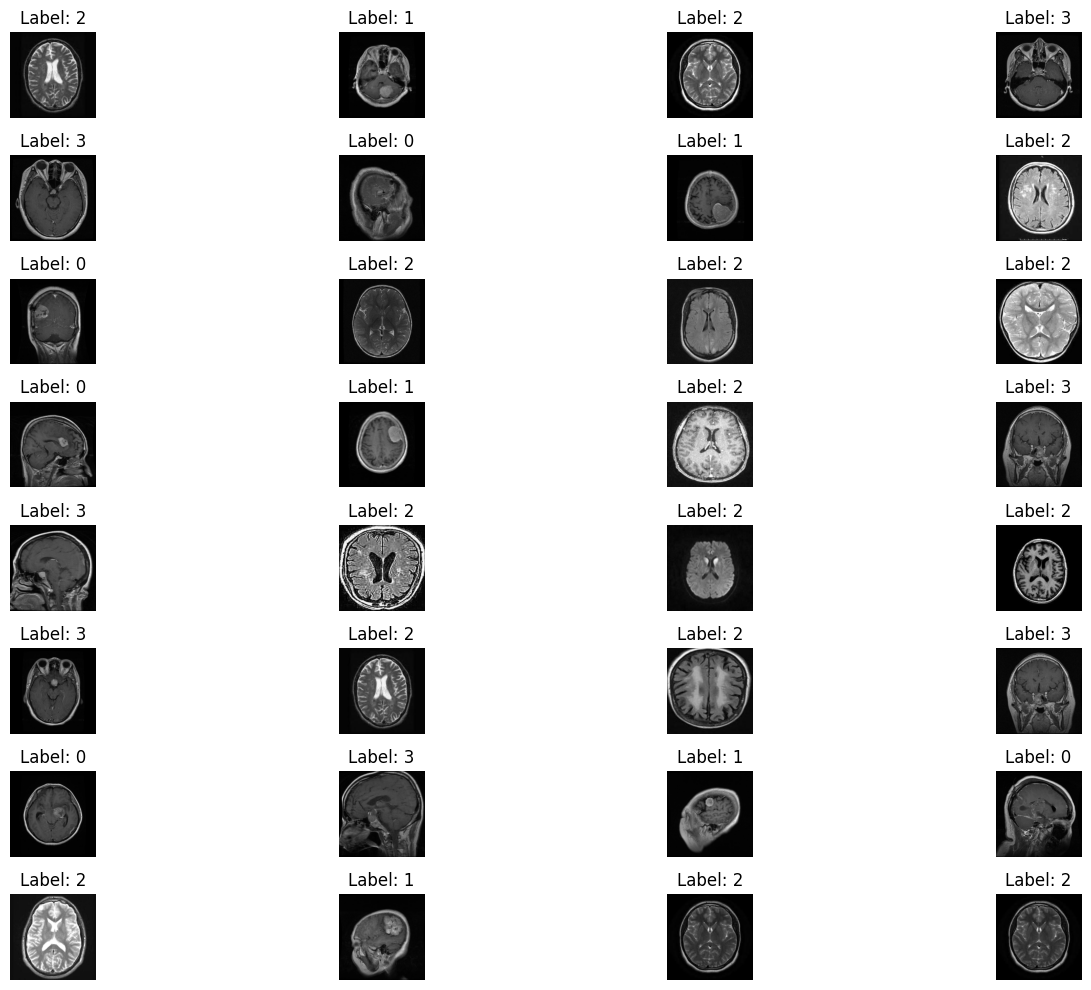

In [ ]:
# transform the images to ensure equal size and tensors
transform = transforms.Compose([
	transforms.Resize((512, 512)),
	transforms.ToTensor(),
	transforms.Grayscale()	
])

train_dataset = btd.BrainTumorDataset(btd.TRAIN_DATA_PATH, transform=transform)

# train_dataset = BrainTumorDataset(train_df, train_dir, transform=transform)
test_dataset = btd.BrainTumorDataset(btd.TEST_DATA_PATH, transform=transform)

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display the images in a grid from one batch in the DataLoader
for imgs, labels in train_loader:
    show_image_grid(imgs, labels, rows = batch_size//4, cols = 4)
    break  

In [ ]:
class VisionTransformer(L.LightningModule):
    def __init__(self, 
                 embedding_dim=64, 
                 patch_size=32, 
                 num_layers=4, 
                 n_heads=8, 
                 dim_feedforward=64):
        super().__init__()
        self.embedding = torch.nn.Conv2d(
            1, embedding_dim, kernel_size=patch_size, stride=patch_size
        )

        # class token for classification
        self.class_token = torch.nn.Parameter(torch.randn(1, 1, embedding_dim))
        # positional embedding
        self.positional_embedding = torch.nn.Parameter(torch.randn(1, 1, embedding_dim))
        # transformer encoder layer
        self.encoder = torch.nn.TransformerEncoder( # we can add a norm between each encoder layer here
            torch.nn.TransformerEncoderLayer( 
                d_model=embedding_dim, nhead=n_heads, dim_feedforward=dim_feedforward
            ),
            num_layers=num_layers,
            enable_nested_tensor=False,
        )
        
		# linear layer for classification
        # TODO

    def forward(self, x):
        x = self.embedding(x)
        # TODO
        return x


# test with random image
model = VisionTransformer(embedding_dim=8)
imgs, labels = next(iter(train_loader))
output = model(imgs[0])
output = output.flatten(start_dim=1)
print(output.shape)

torch.Size([8, 256])


# Pre trained model

In [29]:
import torch.utils


transform = transforms.Compose([
	transforms.Grayscale(num_output_channels=3),	# convert to 3 channels
	transforms.Resize((224, 224)), 					# resize to 224x224
	transforms.ToTensor(),
])

train_dataset = btd.BrainTumorDataset(btd.TRAIN_DATA_PATH, transform=transform)
test_dataset = btd.BrainTumorDataset(btd.TEST_DATA_PATH, transform=transform)

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load pre-trained model
model = vit_b_16(weights='IMAGENET1K_V1')

# Modify for 4 classes
model.heads = torch.nn.Linear(model.hidden_dim, 4) 

model = model.to(device)
summary(model, (3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 768, 14, 14]         590,592
├─Encoder: 1-2                                [-1, 197, 768]            --
|    └─Dropout: 2-1                           [-1, 197, 768]            --
|    └─Sequential: 2-2                        [-1, 197, 768]            --
|    |    └─EncoderBlock: 3-1                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-2                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-3                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-4                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-5                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-6                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-7                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-8            

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 768, 14, 14]         590,592
├─Encoder: 1-2                                [-1, 197, 768]            --
|    └─Dropout: 2-1                           [-1, 197, 768]            --
|    └─Sequential: 2-2                        [-1, 197, 768]            --
|    |    └─EncoderBlock: 3-1                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-2                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-3                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-4                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-5                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-6                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-7                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-8            

In [ ]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # Iterate over the training data
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for current batch
        running_loss += loss.item() * inputs.size(0)

    # Calculate and print average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print("Training complete.")


In [20]:
def hook_fn(module, input, output):
    print(module)
    print(f"Input shape: {input[0].shape}")
    print(f"Output shape: {output[0].shape}")
    print("===")

# Register the hook to the multihead attention module
for module in model.modules():
    if isinstance(module, torch.nn.MultiheadAttention):
        module.register_forward_hook(hook_fn)

In [ ]:
model.load_state_dict(torch.load("model_pretrained.pth", weights_only=True, map_location=device))

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
	correct = 0
	total = 0

	for inputs, labels in tqdm(test_loader, desc="Testing"):
		inputs, labels = inputs.to(device), labels.to(device)
		outputs = model(inputs)
		predictions = torch.argmax(outputs, dim=1)

		total += labels.size(0)
		correct += (predictions == labels).sum().item()

	accuracy = correct / total
	print(f'Accuracy on the test set: {accuracy:.2%}')


In [ ]:
# Define the transformation for the images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # convert to 3 channels
    transforms.Resize((224, 224)),                 # resize to 224x224
    transforms.ToTensor(),
])

# Load your datasets with the defined transformations
train_dataset = btd.BrainTumorDataset(btd.TRAIN_DATA_PATH, transform=transform)
test_dataset = btd.BrainTumorDataset(btd.TEST_DATA_PATH, transform=transform)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def hook_fn(module, input, output):
    print(module)
    print(f"Input shape: {input[0].shape}")
    print(f"Output shape: {output[0].shape}")
    print("===")

# Define the PyTorch Lightning Module
class BrainTumorClassifier(L.LightningModule):
	def __init__(self, learning_rate=1e-4):
		super().__init__()
		# Initialize the model with the pre-trained ViT
		self.model = vit_b_16(weights='IMAGENET1K_V1')
		self.model.heads = torch.nn.Linear(self.model.hidden_dim, 4)  # Modify for 4 classes

		# Define loss function and learning rate
		self.criterion = torch.nn.CrossEntropyLoss()
		self.learning_rate = learning_rate

		# Initialize accuracy metric for logging
		self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)
		self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)

	def forward(self, x):
		return self.model(x)

	def training_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
		self.train_accuracy(outputs, labels)
		self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True)

		return loss

	def validation_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('val_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		return loss

	def configure_optimizers(self):
        # Define the optimizer
		return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
	
	def on_test_start(self):
		# Register the hook to each multi-head attention layer before testing
		for module in self.model.modules():
			if isinstance(module, torch.nn.MultiheadAttention):
				module.register_forward_hook(hook_fn)

# Create the model instance
model = BrainTumorClassifier()

# Define the PyTorch Lightning Trainer
trainer = L.Trainer(max_epochs=3, accelerator="auto")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Andreas\anaconda3\envs\deep_learning\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [ ]:
# Train the model
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

In [ ]:
# Test the model
trainer.test(model, dataloaders=test_loader)